In [2]:
import spikeextractors as se
import spiketoolkit as st
import numpy as np
import matplotlib.pylab as plt
import exdir
import place_stimulation as ps
import expipe
import scipy.signal as ss
import pyintan
import sys
sys.path.append('../mec_theta')
import data_processing as dp
from trackunitmulticomparison import TrackMultipleSessions

%matplotlib notebook

def find_fmax_noise(recording_hp, start_frame=0, end_frame=300000, start_freq=2000, end_freq=4000):
    import scipy.signal as ss
    filt_traces = recording_hp.get_traces(start_frame=start_frame, end_frame=end_frame)
    f, p = ss.welch(filt_traces, recording_hp.get_sampling_frequency())
    idxs = np.where((f > start_freq) & (f < end_freq))

    max_freq = f[idxs][np.squeeze(p[:, idxs]).mean(axis=0).argmax()]
    return max_freq

In [3]:
project_path = dp.project_path()

project = expipe.get_project(project_path)
actions = project.actions

In [4]:
# actions

In [5]:
action = actions['137-310121-8']

In [6]:
check_hp = False
check_lfp = True

In [7]:
data_path = ps.get_data_path(action)

Project path: D:\projects\novel-env
Data path: actions\137-310121-8\data\main.exdir


In [8]:
# check if openephys or intan
exdir_file = exdir.File(str(data_path))
acquisition = exdir_file['acquisition']

In [9]:
attrs = acquisition.attrs

In [10]:
if 'Intan' in attrs['acquisition_system']:
    print('Intan recording')
    prb_file = 'probes/tetrode_32_intan.prb'
    intan = True
    openephys = False
    rhs_file = [x for x in acquisition[attrs['session']].directory.iterdir() if x.suffix == '.rhs'][0]
    f = pyintan.File(str(rhs_file))
    dig_intan = f.digital_in_events
    recording = se.IntanRecordingExtractor(rhs_file)
elif 'FPGA' in attrs['acquisition_system']:
    print('Open Ephys Recording')
    prb_file = 'probes/tetrode_32_openephys.prb'
    openephys = True
    intan = False
    recording = se.OpenEphysRecordingExtractor(str(acquisition[attrs['session']].directory))

Open Ephys Recording
Loading Open-Ephys: reading settings.xml...
Decoding data from  binary  format


In [11]:
# recording = se.load_probe_file(recording, prb_file)
# recording_f = st.preprocessing.bandpass_filter(recording, type='butter', order=5)
# recording_cmr = st.preprocessing.common_reference(recording_f, reference='median', groups=[list(range(16)), list(range(16,32))])

# if intan:
#     notch = find_fmax_noise(recording_cmr)
#     recording_cmr = st.preprocessing.notch_filter(recording_cmr, notch, q=100)
#     if len(dig_intan) > 1:
#         print(dig_intan[1].times)
#         stim_triggers = [int(d) for d in dig_intan[1].times.magnitude[::2] * recording.get_sampling_frequency()]
#         recording_rm = st.preprocessing.remove_artifacts(recording_cmr, np.array(stim_triggers), ms_before=5, ms_after=5)
#     else:
#         recording_rm = recording_cmr
# else:
#     recording_rm = recording_cmr

In [12]:
fs = 30000
fs_lfp = 1000
start_time = 100
end_time = 150

In [13]:
# choose tetrode
tetrode = 4
channel_ids = tetrode*4 + np.arange(4)
print(channel_ids)

[16 17 18 19]


In [14]:
if check_hp:
    traces = recording_rm.get_traces(start_frame=start_time*fs, end_frame=end_time*fs)
    traces_f = recording_f.get_traces(start_frame=start_time*fs, end_frame=end_time*fs)
    timestamps = np.arange(traces.shape[1])/recording.get_sampling_frequency() + start_time
    print(traces.shape, timestamps.shape)

In [15]:
recording.get_sampling_frequency()


30000.0

In [17]:
if check_hp:
    plt.figure()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i, ch in enumerate(channel_ids):
        plt.plot(timestamps, traces[ch] + 600*i, lw=0.5, color=colors[i])
        plt.plot(timestamps, traces_f[ch] + 600*i, lw=0.5, color=colors[i], alpha=0.3)
        if intan:
            [plt.axvline(d, lw=0.3, alpha=0.2) for d in dig_intan[1].times[::2]]

In [18]:
# compute lfp and psd
recording_lfp = st.preprocessing.bandpass_filter(
            recording, freq_min=1, freq_max=300)
recording_lfp = st.preprocessing.resample(
    recording_lfp, 1000)
fs_lfp = 1000


.dat:  continuous.dat
Estimated samples:  21648640  Numchan:  32


In [19]:
recording_lfp.get_sampling_frequency()

1000

In [20]:
if check_lfp:
    traces_lfp = recording_lfp.get_traces(start_frame=start_time*fs_lfp, end_frame=end_time*fs_lfp)
    timestamps_lfp = np.arange(traces_lfp.shape[1])/recording_lfp.get_sampling_frequency() + start_time
    f, p = ss.welch(traces_lfp, fs=fs_lfp, nperseg=2048)

<IPython.core.display.Javascript object>


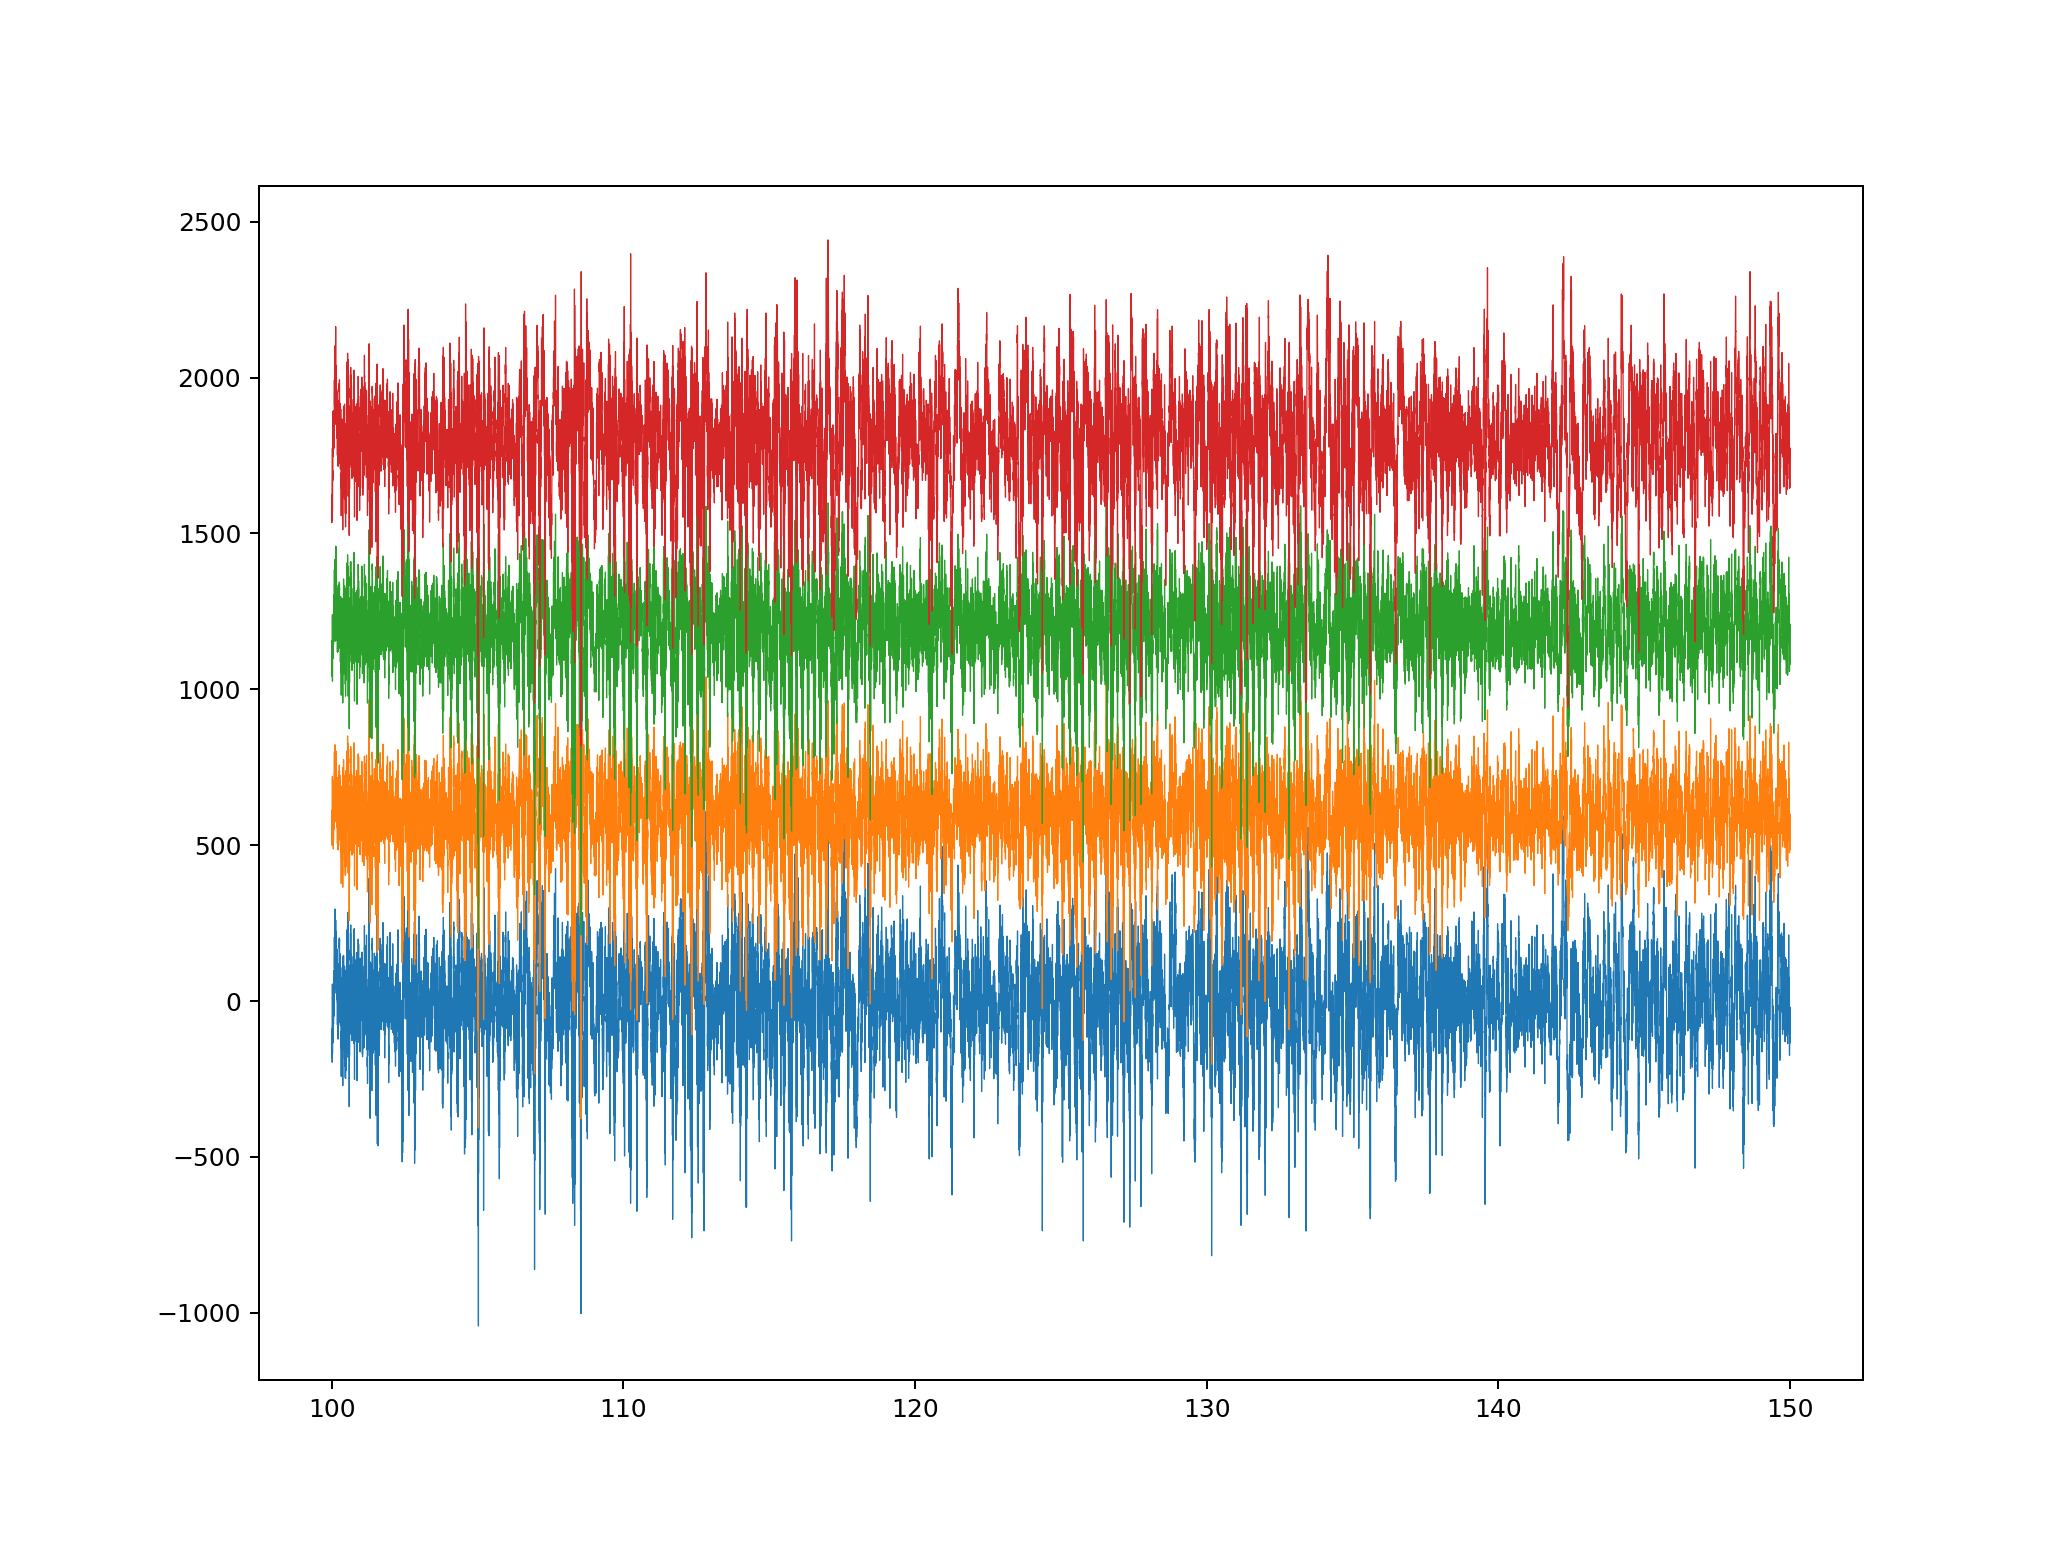

In [17]:
if check_lfp:
    plt.figure()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i, ch in enumerate(channel_ids):
        plt.plot(timestamps_lfp, traces_lfp[ch] + 600*i, lw=0.5, color=colors[i])

<IPython.core.display.Javascript object>


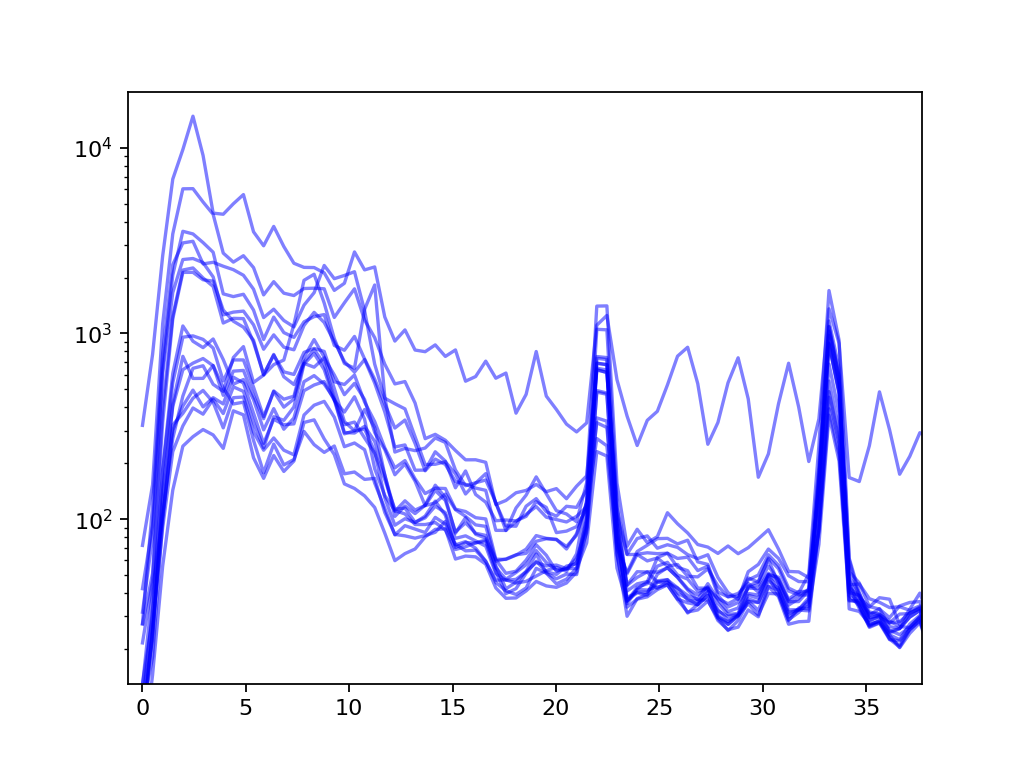

In [20]:
if check_lfp:
    plt.figure()
    f_idx_100 = np.where(f < 100)
    f_100 = f[f_idx_100]
    p_100 = np.squeeze(p[:, f_idx_100])
#     _ = plt.semilogy(f_100, p_100[:16].T, 'r', alpha=0.5) #tetrodes 0-3
    _ = plt.semilogy(f_100, p_100[16:].T, 'b', alpha=0.5) #tetrodes 4-7


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Fixing random state for reproducibility
# np.random.seed(19680801)

dt = 0.0005
t = np.arange(0.0, 20.0, dt)
s1 = np.sin(2 * np.pi * 100 * t)
s2 = 2 * np.sin(2 * np.pi * 400 * t)

# create a transient "chirp"
s2[t <= 10] = s2[12 <= t] = 0

# add some noise into the mix
nse = 0.01 * np.random.random(size=len(t))

x = s1 + s2 + nse  # the signal
NFFT = 1024  # the length of the windowing segments
Fs = int(1.0 / dt)  # the sampling frequency

fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.plot(t, x)
Pxx, freqs, bins, im = ax2.specgram(x, NFFT=NFFT, Fs=Fs, noverlap=900)
# The `specgram` method returns 4 objects. They are:
# - Pxx: the periodogram
# - freqs: the frequency vector
# - bins: the centers of the time bins
# - im: the matplotlib.image.AxesImage instance representing the data in the plot
plt.show()